<strong>License</strong>: BSD<br/>
<strong>Copyright</strong>: Copyright The American Gut Project, 2014

In [1]:
# This cell allows us to render the notebook in the way we wish no matter where
# the notebook is rendered.
from IPython.core.display import HTML
css_file = '../ag.css'
HTML(open(css_file, "r").read())

<a id="intro"></a>
# [Title]

**[text about the topic goes here.]**

<a id="intro_sub1"></a>
## [Subsection 1]
**[Text about optional subsections.]**

<a href="#top">Return to the Table of Contents</a>

<a id="requirements"></a>
## Notebook Requirements
* [Python 2.7.3](https://www.python.org/download/releases/2.7/)
* [Numpy 1.9](http://www.numpy.org)
* [Qiime 1.9](https://www.qiime.org/install/install.html)
* [hdf5](http://www.hdfgroup.org/HDF5/) and [h5py](http://www.h5py.org). This is required to read the American Gut biom tables in Qiime.
* [Jinja2](http://jinja.pocoo.org/docs/dev/), [pyzmq](https://learning-0mq-with-pyzmq.readthedocs.org/en/latest/) and  [tornado](http://www.tornadoweb.org/en/stable/). These are required to open a local IPython notebook instance. hese are required to open a local ipython notebook on your machine. They are not automatically installed with iPython or Qiime.
* [Statsmodels 0.6.0](http://statsmodels.sourceforge.net)
* [American Gut Python Library](https://github.com/biocore/American-Gut)
* $\LaTeX$. [LiveTex](http://www.tug.org/texlive/) offers one installation solution.

<a id="top"></a>
##Table of contents
<ul><li><a href="#intro">Introduction</a>
<ul><li><a href="#intro_sub1">Subsection 1</a>
</li></ul>
</li><li><a href="#requirements">Notebook Requirements</a>
</li><li><a href="#imports">Function Import</a>
</li><li><a href="#params">Analysis parameters</a>
<ul><li><a href="#params_data">Dataset Selection</a>
</li><li><a href="#params_save">File Saving Parameters</a>
</li><li><a href="#params_text">Text File and Metadata Parameters</a>
</li><li><a href="#params_cat">Analysis Category Parameters</a>
</li><li><a href="#params_alpha">Alpha Diversity Parameters</a>
</li><li><a href="#params_beta">Beta Diversity Parameters</a>
</li><li><a href="#params_gs">Group Significance Parameters</a>
</li><li><a href="#params_figs">Plotting Parameters</a>
</li></ul>
</li><li><a href="#dir">Files and Directories</a>
<ul><li><a href="#dir_base">Base Directory</a>
</li><li><a href="#dir_data">Sample Directory and Files</a>
</li><li><a href="#dir_bdiv">Beta Diversity Analsysis Directories and Files</a>
</li><li><a href="#dir_gs">Group Significance Analysis Directories and Files</a>
</li><li><a href="#dir_image">Image Directories and Files</a>
</li></ul>
</li><li><a href="#download">Data Download</a>
</li><li><a href="#alpha">Alpha Diversity</a>
</li><li><a href="#beta">Beta Diversity</a>
</li><li><a href="#group">Group Significance</a>
</li><li><a href="#discussion">Discussion</a>
</li><li><a href="#refs">References</a>
</li></ul>

<a id="imports"></a>
## Function Import
We start by importing necessary functions, and determining if files should be overwritten.

In [2]:
import os
import shutil

import scipy
import skbio
import biom
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import americangut.diversity_analysis as div

from matplotlib import rcParams

We will also set up some plotting parameters so the generated figures use Helvetica or Arial as their default font. For more on font properties, see the matplotlib documentation on [text objects](http://matplotlib.org/api/text_api.html?highlight=font#matplotlib.text.Text.set_fontproperties) and [rendering text with LaTex](http://matplotlib.org/users/pgf.html?highlight=font). We will also prompt the IPython notebook to display the images we generate live in the notebook.

In [3]:
# Displays images inline
%matplotlib inline

# Sets up plotting parameters so that the default setting is use to 
# Helvetica in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True

<a href=#top>Return to the top</a>

<a id="params"></a>
## Analysis Parameters
We can also set some necessary parameters for handling files and this analysis. It’s easier to set them as a block, here, so that our systems are consistent than to modify each of the variables later in the import if our needs or our data changes.

<a id="params_data"></a>
### Dataset Selection
We will start by selecting which dataset we’d like to use for this analysis. We can select to work with the full OTU table or focus on a single body site. We can also choose which grouping of this data we’d like to use, limiting the analysis to a certain subset of the American Gut Population.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site</strong><br>
(<code style="color:Firebrick;background-color:#D0D0D0">"all"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"fecal"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"oral"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"skin"</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This identifies the bodysite where the analysis should be analyzed. It is recommended that categorical analysis focus on a single bodysite, since location on the human body has the largest effect on the microbial communities at those sites in relatively healthy adults and children four years of age and older [<a href="#22699611">22699611</a>; <a href="#22699609">22699609</a>].
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>dataset</strong><br>(
            <code style="color:Firebrick;background-color:#D0D0D0">""</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"all_participants_all_samples"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"all_participants_one_sample"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"sub_participants_all_samples"</code>,
            <code style="color:Firebrick;background-color:#D0D0D0">"sub_participants_one_sample"</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p><strong><code>dataset</code></strong> identifies the subset of samples to be used 
            for analysis.</p> 
            <p>If the <strong><code>site</code></strong> is <code><font color="Firebrick">"all"</font></code>, the <strong><code>dataset</code></strong> should be <code><font color="Firebrick">""</font></code>. <br>
            There are not multiple subsets of samples avaliable for all data, if data was generated 
            through the preprocessing notebook.</p>
            <p>For site-specific analyses, every site has data for all participants and all 
            samples.
            Each individual’s microbiome is correlated with itself 
            [<a href="#21624126">21624126</a>, <a href="#21885731">21885731</a>], so to allow 
            multiple samples per individual violates an assumption of independence used in many statistical tests. Therefore, the 
            Preprocessing Notebook draws a single sample for each individual at each bodysite.</p>
            <p>We may also choose to work with a subset of the data. The preprocessing notebook 
            selects a healthy subset of adult participants. This includes individuals between 20 
            and 70 who have a BMI between 18.5 and 30. Additionally, these individuals cannot have 
            been diagnosed with IBD or diabetes and do not report using antibiotics in the past
            year.</p>
        </td>
    </tr>
</table>

In [4]:
site = 'fecal'
dataset = 'all_participants_one_sample'

<a id="params_save"></a>
### File Saving Parameters

In the course of this analysis, a series of files can be generated. The File Saving Parameters determine if new files are saved.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>overwrite</strong><br />(boolian)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>When <strong><code>overwrite</code></strong> is 
            <code><font color="228B22">True</font></code>, new files will
            be generated and saved during data processing. <br>It is 
            recommended that overwrite be set to 
            <code><font color="228B22">False</font></code>, in which case 
            new files will only be generated when the file does not exist. 
            This substantially decreases analysis time.</p>
            <p><strong><code>overwrite</code></strong> will also cause the 
            notebook to generate new post-hoc beta diversity comparisons, 
            even if the files exist. This can be computationally 
            expensive, and scales with the number of groups in a metadata 
            category and the number of samples.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>save_images</strong><br>(boolian)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This notebook will generate images of the power curves. By 
            default, these will be displayed inside the notebook. However, 
            some users also find it advantageous to save the images.
            The file format can be set with the 
            <a href="#dir_analysis"><strong><code>image_pattern</code></strong></a>.
        </td>
    </tr>
</table>

In [5]:
overwrite = False
save_images = True

<a href="#top">Return to the top</a>

<a id="params_text"></a>
### Text File and Metadata Parameters
Qiime-formatted metadata and results files are frequently tab-separated text (.txt) files. These files can be opened in Excel or spreadsheet programs. You can learn more about Qiime mapping files [here](http://qiime.org/documentation/file_formats.html). We use the Pandas library to read most of our text files, which provides some spreadsheet like functionalities.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>txt_delim</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <strong><code>txt_delim</code></strong> specifies the way columns are separated in the files. Qiime typically consumes and produces tab-delimited (<code><font color="FireBrick">"\t"</font></code>) text files (.txt) for metadata and results generation.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
              <strong>map_index</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The name of the column containg the sample names. In Qiime, this column is called <code><font color="FireBrick">#SampleID</font></code>.
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>map_nas</strong><br />(list of strings)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            t is possible a mapping file map be missing values, since American Gut participants are free to skip any question. The pandas package is able to omit these missing samples from analysis. In raw American Gut files, missing values are typically denoted as <code><font color="FireBrick">“NA”</font></code>, <code><font color="FireBrick">“no_data”</font></code>, <code><font color="FireBrick">“unknown”</font></code>, and empty spaces (<code><font color="FireBrick">“”</font></code>).
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>write_na</strong><br /> (string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The value to denote missing values when text files are written from Pandas data frames. Using an empty space, (<code><font color="FireBrick">“”</font></code>) will allow certain Qiime scripts, like [group_signigance.py](http://qiime.org/scripts/group_significance.html), to ignore the missing values.
        </td>
    <tr>

    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>date_cols</strong><br /> (list of strings)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            Temporal data can be identified using the <strong><code>date_cols</code></strong>, allowing the Pandas program to do time-based analysis. In the American Gut dataset, there are four we identify initially: 
            <ul><li>*BIRTH_DATE*          (the participant’s birthdate)
            </li><li>*COLLECTION_DATE*    (the day the sample was collected)
            </li><li>*SAMPLE_TIME*        (the time the sample was collected)
            </li><li>*RUN_DATE*           (the day the samples were sequenced)
            </li></ul>
        </td>
    <tr>
</table>

In [6]:
# Sets parameters for file handling and reading tables
# into pandas
txt_delim = '\t'
map_index = '#SampleID'
map_nas = ['NA', 'no_data', 'unknown', '']
write_na = ''
date_cols = ['RUN_DATE', 'COLLECTION_DATE', 'BIRTH_DATE', 'SAMPLE_TIME']

<a href="#top">Return to the top</a>

<a id="params_cat"></a>
### Analysis Category Parameters
We will focus the analysis within each notebook on a metadata category, which represents a column within the mapping file. This will serve as the basis for the analysis of alpha diversity, beta diversity, and looking at the OTU abundances. This template focuses on categorical or ordinal meta data, not continuous metadata.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>category</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The name of the column in the mapping file being analyzed. This should be an ordinal or continuous category where at least two defined groups are present. </p><p>For example, analyzing the category, <em>PHENYLKETONURIA</em> (does the participant have the medical condition, Phenylketonuria (PKU)?) for American Gut Rounds 1 - 14 would be a poor choice, since no participant in that sample set reports having PKU. </p><p>Analysis of age or body mass index (both continuous variables) for this dataset should be using binned variables, for example, <em>AGE_CAT</em> or <em>BMI_CAT</em>.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>order</strong><br>(list; <code style="color:#228B22;background-color:#D0D0D0">None</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            Many of the variables used in the American Gut analysis have some intrinsic order. It would seem strange, for instance, to find seasons order FALL, SPRING, SUMMER, WINTER rather than FALL, WINTER, SPRING, SUMMER. This also maintains consistent ordering between scripts. If there is no intrinsic order for the data, and no implied order should be imposed, <strong><code>c_order</code></strong> can be set to <code><font color="#228B22">None</font></code>.
        </td>
    </tr>
</table>


In [43]:
# Categorical Parameters
category = 'AGE_CAT'
c_order = ['baby', 'child', 'teen', '20s', '30s', '40s', '50s', '60s', '70+']

<a href="#top">Return to the top</a>

<a id="params_alpha"></a>
### Alpha Diversity Parameters

<p>This notebook will compare alpha diversity and beta diversity for the category selected.  Alpha diversity is a comparison of intra-community variation. When alpha diversity values are compared, the comparison does not take into account the community structure. So, two communities which share no species can have the same alpha diversity. American Gut Analyses primarily focus on an alpha diversity metric called PD Whole Tree Diversity [<a herf="#15831718">15831718</a>]. PD Whole Tree is phylogenetically aware, meaning that it takes into account shared evolutionary history.</p>
<p>We will compare alpha diversity using a [kruskall-wallis test](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance), and we will plot the results as a [boxplot](http://en.wikipedia.org/wiki/Box_plot). We can set parameters for the way we make the comparison and how the figure will look.</p>


<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_div_metric</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The alpha diversity metric to be used in the analysis. Mapping files generated by the Preprocessing Notebook have a set of mapping columns appended which provide the mean for several metrics. These are labeled as the metric name with <font color="firebrick"><code>“_mean”</code></font> appended to the end, to indicate the values are the mean of 10 rarefactions.</p>
<p>There are multiple alpha diversity metrics which can be used. The preprocessing notebook calculates four possible alpha diversity metrics for the data (PD Whole Tree Diversity [<a href="#15831718">15831718</a>], Shannon Diversity [<a href="#shannon">Shannon</a>], Chao1 diversity [<a href="#chao1">Chao</a>], and Observed Species diversity). The default value used here, <code><font color="Firebrick">“PD_whole_tree_mean”</font></code>, is the only metric which takes into account the evolutionary relationship between organisms in a sample.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_ylabel</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This y-label appears on the boxplot to help clarify the information presented there. Alpha diversity is a unitless quantity.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_ylim</strong><br />(2 element list of numbers)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This specifies the limits for the y axis. Limits should be set as a function of the diversity metric. With PD whole tree diversity, limits of <code>[5, 55]</code> is suggested. For shannon diversity, <code>[0, 8]</code> should be used as limits. Chao1 diversity has a larger range, and <code>[100, 1000]</code> can be used as limits. Observed Species also has a larger range, and <code>[0, 800]</code> may be an appropriate starting place.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_title</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The title to be displayed over the alpha diversity boxplot.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>a_correct</strong><br />(string, <code style="color:#228B22;background-color:#D0D0D0">None</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
A post-hoc table, comparing the samples within each metadata category, accompanies the alpha diversity boxplot. If a post hoc correct is desired, the method can be specified using a_correct. FDR correction can be specified by <code><font color="Firebrick">"fdr_bh"</font></code>, while the more conservative Bonferroni correction is given by <code><font color="Firebrick">"bonferroni"</font></code>. Other correction methods can be viewed [here](http://statsmodels.sourceforge.net/stable/generated/statsmodels.sandbox.stats.multicomp.multipletests.html#statsmodels.sandbox.stats.multicomp.multipletests). A value of <code><font color="#228B22">None</font></code> will not correct for multiple hypotheses.
        </td>
    </tr>
</table>


In [8]:
# Alpha Diversity Parameters
a_div_metric = 'PD_whole_tree_mean'
a_ylabel = 'PD Whole Tree Mean'
a_ylim = [5, 55]
a_title = 'Age by Decade'
a_correct = 'fdr_bh'

<a href="#top">Return to the top</a>

<a id="params_beta"></a>
## Beta Diversity Parameters

Beta diversity looks at the difference in community structure across two communities. Each metric calculates a distance between the communities, which is reflective of their difference. American Gut Analyses have calculated weighted and unweighted UniFrac distance for the communities [<a href="#16332807">16332807</a>]. UniFrac distance takes into account the evolutionary relationship between samples, by determining what fraction of evolutionary history is different between two samples. Weighted UniFrac also takes into account the relative abundance of each taxa, while unweighted UniFrac distance only considers presence and absence. We will compare intra and intergroup UniFrac distances using permutation tests. We will plot the distance between samples as a bar chart. 

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_div_metric</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The beta diversity metric to be used in the analysis. This name will appear at the beginning of the distance matrix file.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>permanova_iter_n</strong><br />(int)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            Differences in beta diversity are frequently tested using a <a href="http://en.wikipedia.org/wiki/Resampling_statistics">permutative test</a> [<a href="#Bondini">Bondini</a>]. This takes care of many of the statistical constraints associated with distance matrices. <strong><code>permanova_iter_n</code></strong> sets the number of iterations to be used for an over-all permanova comparison of beta diversity. If the overall p value is greater than 0.01, an error message will be returned, rather than a boxplot. Note that for iteratively calculated p values, the p value cannot be less than $\frac{1}{number\textrm{ }of \textrm{  } permutation + 1}$.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>post_iter_n</strong><br />(int)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
The number of iterations to use for the calculation of p values in post-hoc testing between groups. This may be set to a different value than that used for the over-all permanova, although it is subject to the same restrictions on the minimum <em>p</em> value.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>p_column</strong><br />(
<code style="color:Firebrick;background-color:#D0D0D0">Parametric p-value</code>,
<code style="color:Firebrick;background-color:#D0D0D0">Parametric p-value (Bonferroni-corrected)</code>,
<code style="color:Firebrick;background-color:#D0D0D0">Nonparametric p-value</code>,
<code style="color:Firebrick;background-color:#D0D0D0">Nonparametric p-value (Bonferroni-corrected)</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The beta_diversity_bars function assumes that post-hoc testing was performed using the Qiime script, <a href="http://qiime.org/scripts/make_distance_boxplots.html">make_distance_boxplots.py</a>. This generates a table with four possible p-values for each comparison:</p> 
            <ul><li><code><font color="Firebrick">Parametric p-value</font></code>
            </li><li><code><font color="Firebrick">Parametric p-value (Bonferroni-corrected)</font></code>
            </li><li><code><font color="Firebrick">Nonparametric p-value</font></code>
            </li><li><code><font color="Firebrick">Nonparametric p-value (Bonferroni-corrected)</font></code>
            </li></ul>
<p>Our recommendation is <code><font color="Firebrick">“Nonparametric p-value”</font></code>, since this does not make an underlying assumption of normality about the distance matrix. The use of <code><font color="Firebrick">“Nonparametric p-value (Bonferroni-corrected)”</font></code> is not recommended, since it pays a multiple hypothesis correction penalty both in permutation number and bonferroni correction [<a href="#18939983">18939983</a>].</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_refs</strong><br />(string, list)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            Our beta diversity plots will compare the distance within a reference group to the distance between a reference group and the other groups. The reference group or groups can be specified by the <strong><code>b_ref</code></strong> variable. We can limit which refrence groups we show (which may be necessary for larger comparisons, like comparing across 12 months), but setting <strong><code>ref_groups</code></strong> to <strong><code>c_order</code></strong> will allow us to display all the comparisons.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_cmap</strong><br />(string, array)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The colormap used for the barcharts can be passed using <strong><code>b_cmap</code></strong>. 
            </p><p>This can either be a string representing a colormap name from <a href="http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps">the list of available colormaps</a>, reversed colormaps (denoted by adding a <code><font color="Firebrick">‘_r’</font></code> to the end of a colormap string, for example <code><font color="Firebrick">‘Blues_r’</font></code>) or a 3 x n or 4 x n numpy array can be used to specify a colormap, where <em>n</em> is greater than or equal to the number of groups.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_ylabel</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This y-label appears on the bar chart to help clarify the information presented there. Unifrac distance is a unitless quantity.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_ylim</strong><br />(2 element list of numbers)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            This specifies the limits for the y axis. Limits should be set as a function of the diversity metric. Unweighted UniFrac must be between 0 and 1, inclusive. Weighted UniFrac can have values above 1.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>b_title</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The title to be displayed on the beta diversity power curve.
        </td>
    </tr>
</table>


In [9]:
# Beta Diversity Parameters
b_div_metric = 'unweighted_unifrac'
permanova_n_iter = 999
post_n_iter = 999
p_column = 'Nonparametric p-value'
b_refs = c_order
bc_map = 'Blues'
ubd_ylabel = 'Unweighted UniFrac Distance'
b_title = 'Age by Decade'
b_ylim = [0.55, 0.95]
b_label_size = 9

<a href="#top">Return to the top</a>

<a id="params_gs"></a>
## Group Signifigance Parameters

In addition to looking at community structure, we can look for differences in the abundance of individual OTUs or taxa. There are multiple comparison methods for identifying OTUs which differ between groups. We can look at the relative abundance of taxa in the rarefied data using a kruskal-wallis test. We will also look for a difference in presence/absence of the OTU or taxa using a g-test. We plot the significant OTUs as a heatmap representing the sample means both for the raw value and a heatmap showing the log ratio of the sample means to the overall mean or a reference group.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>hm_cap1</strong>;<br /><strong>hm_cmap2</strong><br />(string, cmap)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The colormap used for the barcharts can be passed using <strong><code>b_cmap</code></strong>. This can either be a string representing a colormap name from <a href="http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps">the list of available colormaps</a>, reversed colormaps (denoted by adding a <code><font color="Firebrick">‘_r’</font></code> to the end of a colormap string, for example <code><font color="Firebrick">‘Blues_r’</font></code>) or a <a href="http://matplotlib.org/api/cm_api.html">matplotlib colormap object</a>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>hm_clims2</strong><br>(2 element list of numbers)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The limits for the color display on the ratio heatmap. If using a two color, diverging colormap (i.e <code><font color="Firebrick">“RdBu”</font></code>), it is suggested that these be positive and negative values of the same magnitude (i.e. <code>[-3, 3]</code>).
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>hm_xtick_size</strong><br /><strong>hm_ytick_size</strong><br/>(int)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
The font size for the respective axis labels. The x-axis will display the group labels. The y-axis will show OTU or taxonomy group labels in the heatmaps.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>kw_crit</strong><br /><strong>gt_crit</strong><br/>(float)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The critical value for evaluating the bonferroni-corrected values of the kruskal wallis and g-test results, respectictly. The g-test is somewhat more permissive, and so we choose to use a lower signifigance threshhold (meaning that there has to be a larger difference for OTUs to be included.)
        </td>
    </tr>
</table>

In [27]:
hm_cmap1 = 'Greens'
hm_cmap2 = 'RdBu_r'

hm_clims2 = [-3, 3]

hm_xtick_size = 12
hm_ytick_size = 10

kw_crit=0.05
gt_crit=0.001

<a href="#top">Return to the top</a>

<a id="params_figs"></a>
## Plotting Parameters

We will visualize the results of our statistical tests on alpha and beta diversity and group significance. We can control the rotation of the text in our figures, as well as what happens when the files are saved.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>xtick_angle</strong><br>(integer between 0 and 359; 
            <code style="color:Firebrick;background-color:#D0D0D0">horizontal</code>;
            <code style="color:Firebrick;background-color:#D0D0D0">vertical</code>)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The rotation to be used on label text in figures. If labels are particularly long (i.e. <em>“Rarely, a few times/week”</em>), label rotation of 45 degrees is recommended. For shorter labels, an angle of 0 or <code><font color="Firebrick">horizontal</font></code> is appropriate.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>xtick_align</strong><br>(
<code style="color:Firebrick;background-color:#D0D0D0">"left"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"right"</code>, 
<code style="color:Firebrick;background-color:#D0D0D0">"center"</code>
)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The text alignment for the labels. We find rotated labels should have a <code><font color="Firebrick">"right"</font></code> alignment. Non-rotated or horizontal labels often look best with <code><font color="Firebrick">"center"</font></code> alignment.
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>save_pad</strong><br />(tuple)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The extra space (in inches) for display around the edge of the figure.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>save_bbox</strong><br />(tuple, str)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The size of the image to be saved. Using a value of <code><font color="Firebrick">'tight'</font></code> will display the entire figure and allow padding.
        </td>
    </tr>
</table>

In [28]:
xtick_angle = 45
xtick_align = 'right'

save_pad = 0.5
save_bbox = 'tight'

<a href="#top">Return to the top</a>

<a id="dir"></a>
## Files and Directories

We need to import working OUT data for analysis and set up a location where results from our analysis can be saved. This notebook consumes pre-processed tables (OTU tables, mapping files and distance matrices) produced by the Preprocessing Notebook. These can be downloaded individually, or the whole set is available [here](https://www.dropbox.com/s/q7wrf4tme2mrt0p/all_samples.tgz).

As we set up directories, we’ll make use the of the **check_dir** function. This will create the directories we identify if they do not exist.

<a id="dir_base"></a>

### Base Directory

We need a general location to do all our analysis; this is the base_dir. All our other directories will exist within the **$base_dir$**, and allow us to work. The working directory is a directory within the base directory where we’ll find the files we need.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>base_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the directory where any files associated with the analysis should be saved. It is suggested this be a directory called <strong>agp_analysis</strong>, and be located in the same directory as the IPython notebooks.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>working_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The file path for the directory where all data files associated with this analysis have been stored. This should contain the results of the Preprocessing Notebook.<br>
The working_dir is expected to be a directory called <strong>sample_data</strong> in the <strong><code>base_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>analysis_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The file path where analysis results should be stored. This is expected to be a folder in the <strong><code>base_dir</code></strong>.
        </td>
    </tr>
</table>

In [29]:
# Sets up the base directory
# base_dir = os.path.join(os.path.abspath('.'), 'agp_analysis')
base_dir = '/Users/jwdebelius/Desktop/agp_analysis2/'
div.check_dir(base_dir)

# Sets up data directory
working_dir = os.path.join(base_dir, 'sample_data')
div.check_dir(working_dir)

# Sets up the analysis directory
analysis_dir = os.path.join(base_dir, 'analysis_results')
div.check_dir(analysis_dir)

<a href="#top">Return to the top</a>
<a id="dir_data"></a>
### Sample Directory and Files

We’ll focus our analysis on fecal samples, which we set with the <a href="#params_data"><strong><code>site</code></strong></a> variable. We’ve chosen to focus on a single sample from a healthy subset of adults in the American Gut population (set with the <strong><code><a href="#params_data">dataset</a></code></strong> variable). To be included in this group, a sample must come from a donor between the ages of 20 and 69 (inclusive) who has a BMI between 18.5 and 30 and does not report having IBD or diabetes.  
Our analysis will use a mapping file, OTU table and unweighted UniFrac distance matrix.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the directory where data sets from fecal samples are stored. This should be a directory in the <strong><code>working_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath of the subset participants single sample directory. This should be a folder in the <strong><code>site_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_map_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>This specifies the filepath for the metadata file associated with the fecal samples. This should be a text file (.txt) in the <strong><code>data_dir</code></strong>.</p>
<p>A mapping file allows us to relate information about the sample to information about the microbiome. This contains a barcode used to identify each sample, and information about the participants from the survey, such as age, diet, or disease status. This cannot be used identify participants and does not contain data like names, physical or email addresses. In the rarefied mapping file (the filenames contain even10k), the mapping file also contains alpha diversity results for each sample. </p>
<p>The notebook expects the metadata to be processed through the Preprocessing notebook, which involved converting continuous categories to categorical data. The rarefied file (<code>AGP_100nt_even10k…</code>), which contains alpha diversity results, is required.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_otu_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
<p>The filepath for the otu table file associated with the fecal samples. This should be a <a href="http://www.biom-format.org">biom-format</a> file (.biom) in the <strong><code>data_dir</code></strong> [<a href="#23587224">23587224</a>].</p>
<p>The OTU table is assumed to be rarefied to an even depth. This is designated in the filename with the phrase, “even10k”, indicating the OTU table has been rarefied to 10,000 sequences per sample.</p>
<p>An OTU table gives the bacterial counts in each sample. An OTU, or operational taxonomic unit, is technically a cluster of sequence at a certain level of similarity. We use sequence clustering to account for PCR and read error. The level of similarity used here, 97% gives approximately genus level resolution [<a href="#17586664">17586664</a>]. Multiple OTUs may map to a single bacterial taxa.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_bdiv_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The filepath for the unweighted UniFrac distance matrix file associated with the fecal samples. This should be a text file (.txt) in the <strong><code>data_dir</code></strong>.</p>
The distance matrix relates the microbiome composition in each sample community to every other community. Unweighted UniFrac distance considers shared evolutionary history and the presence or absence of OTUs in this calculation [<a href="#16332807">16332807</a>]. Identical communities have a UniFrac Distance of 0, while communities which have no shared history have a UniFrac distance of 1.
        </td>
    </tr>
</table>

In [30]:
# Sets up OTU path directories
site_dir = os.path.join(working_dir, site)
div.check_dir(site_dir)

data_dir = os.path.join(site_dir, dataset)

# Sets the subset filepath for all samples
data_otu_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.biom')
data_map_fp = os.path.join(data_dir, 'AGP_100nt_even10k_fecal.txt')
data_ubd_fp = os.path.join(data_dir, '%s_AGP_100nt_even10k_fecal.txt') % b_div_metric

<a href="#top">Return to the top</a>
<a id="dir_bdiv"></a>
### Beta Diversity Directories and Files

Some of the analyses we will be performing will result in files for analysis. This will follow a file structure similar to the one used with the OTU tables. We will use the qiime script, <a href="http://qiime.org/scripts/make_distance_boxplots.html">make_distance_boxplots.py</a> to do iterative, pair-wise testing between the groups in our metadata category.


<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>bdiv_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The parent directory for the beta diversity results. This expected to be a directory in the <strong><code>analysis_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>bdiv_site_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            A body-site specific directory for beta diversity comparison results. This is expected to be a directory in the <strong><code>bdiv_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>bdiv_data_dir</strong><br />(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            <p>The directory for the specific dataset used in the analysis. For example, a comparison based on age could be performed on a single sample per participant among the healthy subset of adults (one_sample_sub_participants) and a single sample per participant for all participants (one_sample_all_participants) to see if the trends seen in the healthy subset hold true as the data set expands.</p>
<p>This is expected to be a directory in <strong><code>bdiv_site_dir</code></strong>.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>bdiv_data_metric_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
Since its possible someone may want to look at multiple metrics for beta diversity and this information is not included in the <a href="http://qiime.org/scripts/make_distance_boxplots.html">make_distance_boxplots.py</a> results, we make separate directories for each distance metric being examined.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>bdiv_post_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the post-hoc beta diversity results. This should be a text file (.txt) in the <strong><code>data_metric_bdiv_dir</code></strong>.
        </td>
    </tr>
</table>


In [31]:
bdiv_dir = os.path.join(analysis_dir, 'beta_diversity')
div.check_dir(bdiv_dir)

bdiv_site_dir = os.path.join(bdiv_dir, site)
div.check_dir(bdiv_site_dir)

bdiv_data_dir = os.path.join(bdiv_site_dir, dataset)
div.check_dir(bdiv_data_dir)

bdiv_data_metric_dir = os.path.join(bdiv_data_dir, b_div_metric)
div.check_dir(bdiv_data_metric_dir)

bdiv_post_fp = os.path.join(bdiv_data_metric_dir, '%s_Stats.txt') % category

<a href="#top">Return to the top</a>
<a id="dir_gs"></a>
### Group Signifigance Directories and Files
We will use the qiime script, [group_signifiance.py](http://qiime.org/scripts/group_significance.html) to look for OTUs which differ between groups within the metadata category we’re examining. The file structure we’ll use for these results will parallel the structure with our data.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>gs_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
The parent directory for the beta diversity results. This expected to be a directory in the <strong><code>analysis_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>gs_site_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            A body-site specific directory for the group signifigance results. This is expected to be a directory in the <strong><code>gs_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_gs_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
<p>The directory for the specific dataset used in the analysis. For example, a comparison based on age could be performed on a single sample per participant among the healthy subset of adults (one_sample_sub_participants) and a single sample per participant for all participants (one_sample_all_participants) to see if the trends seen in the healthy subset hold true as the data set expands.</p>
<p>This is expected to be a directory in <strong><code>gs_site_dir</code></strong>.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>gs_data_otu_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
<p>The directory where OTU table specific results should be stored. We may choose to collapse our OTU table by taxonomy (see the qiime script <a href="http://qiime.org/scripts/summarize_taxa.html">summarize_taxa.py</a>), which also generates biom-format files suitable for consumption by <a href="http://qiime.org/scripts/group_significance.html">group_signifigance.py</a>.</p>
<p>This is expected to be a directory in <strong><code>gs_data_dir</code></strong>.</p>
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>kruskal_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filepath for the results of the <a href="http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance">kruskal wallis</a> test. A kruskal-wallis test looks for differences in abundance between groups. 
This should be a text file in the <strong><code>gs_data_otu_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>gtest_fp</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
The filepath for the results of the <a href="http://en.wikipedia.org/wiki/G-test">g-test</a>. A g-test looks for difference in the presence or absence of a taxa between groups.
This should be a text file in the <strong><code>gs_data_otu_dir</code></strong>.
        </td>
    </tr>
</table>


In [32]:
gs_dir = os.path.join(analysis_dir, 'group_signifigance')
div.check_dir(gs_dir)

gs_fecal_dir = os.path.join(gs_dir, site)
div.check_dir(gs_fecal_dir)

gs_data_dir = os.path.join(gs_fecal_dir, dataset)
div.check_dir(gs_data_dir)

gs_data_otu_dir = os.path.join(gs_data_dir, 'otus')
div.check_dir(gs_data_otu_dir)

kruskal_fp = os.path.join(gs_data_otu_dir, '%s_kw.txt') % category
gtest_fp = os.path.join(gs_data_otu_dir, '%s_gt.txt') % category

<a href="#top">Return to the top</a>
<a id="dir_image"></a>
### Image Directories and Files

We can save the graphical results of our analysis, in addition to displaying them in the notebook. We will use a file structure similar to the way we’ve saved our OTU tables to keep track of the images generated.

<table style="width:90%;
              border-style:hidden;
              borders-collapse:collapse;
              line-height:120%">
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The parent directory for the images generated by the notebook. This expected to be a directory in the <strong><code>analysis_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>site_image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
    
A body-site specific directory for the result images. This is expected to be a directory in the <strong><code>image_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>data_image_dir</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The directory for the specific dataset used in the analysis. For example, a comparison based on age could be performed on a single sample per participant among the healthy subset of adults (one_sample_sub_participants) and a single sample per participant for all participants (one_sample_all_participants) to see if the trends seen in the healthy subset hold true as the data set expands.
This is expected to be a directory in <strong><code>image_site_dir</code></strong>.
        </td>
    </tr>
    <tr>
        <td style="width: 30%;
                   text-align:left; 
                   vertical-align:top;
                   background-color:#D0D0D0;
                   border-right:hidden; 
                   border-bottom: 10px solid white;
                   padding:10px">
            <strong>image_pattern</strong><br>(string)
        </td>
        <td style="width: 60%
                   text-align: left;
                   vertical-align: top;
                   border-left:hidden;
                   border-top:hidden;
                   border-bottom:hidden;
                   padding:10px;
                   ">
            The filename to be used for saving results images we generate. This uses file replacement. We can generate a dictionary object where we identify the value that will fill in the blanks. The code, <code><font color="Firebrick">"%s"</font></code> allows a string.
        </td>
    </tr>
</table>

In [33]:
image_dir = os.path.join(analysis_dir, 'images')
div.check_dir(image_dir)

site_image_dir = os.path.join(image_dir, site)
div.check_dir(site_image_dir)

data_image_dir = os.path.join(site_image_dir, dataset)
div.check_dir(data_image_dir)

image_pattern = os.path.join(data_image_dir, '%(div_metric)s_%(image_type)s_%(category)s.png')

<a href="#top">Return to the top</a>
<a id="download"></a>
## Data Download

We will start our analysis using the clean, rarefied tables generated by the Preprocessing Notebook. If necessary, these files can be downloaded. The necessary files are then loaded into the notebook for analysis and processing.

In [34]:
# Gets data for single samples with all the OTUs
if not os.path.exists(data_dir) or overwrite:
    # Downloads the files
    !curl -OL https://www.dropbox.com/s/5gx2whigjhlcdhv/sub_participants_one_sample.tgz
    # Extracts the data
    !tar -xzf sub_participants_one_sample.tgz
    # Moves the data
    os.remove(os.path.join('.', 'all_participants_one_sample.tgz'))
    shutil.move(os.path.join('.', 'all_participants_one_sample'), site_dir)

In [35]:
# Loads the files into the notebook
data_otu = biom.load_table(data_otu_fp)
data_map = pd.read_csv(data_map_fp,
                       sep=txt_delim, 
                       na_values=map_nas,
                       parse_dates=date_cols,
                       index_col=False)
data_map.index = data_map[map_index]
del data_map[map_index]
data_ubd = skbio.DistanceMatrix.read(data_ubd_fp)

In [36]:
data_map.shape

(1907, 206)

### Filters the data to ignore samples which may confound the analysis

In [37]:
subset_f = { # 'AGE': lambda x: 19 < x < 70 and not np.isnan(x),
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
#             'BMI': lambda x: 18.5 <= x < 30 and not np.isnan(x)
           }
# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = data_map[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = pd.DataFrame(new_bin)

data_map = data_map.loc[bin_frame.all(1)]

In [40]:
data_map_fp = '/Users/jwdebelius/Desktop/antibiotics_map.txt'
data_map.to_csv(data_map_fp, sep=txt_delim, rep_na=write_na, index_label=map_index)

<a href="#top">Return to the top</a>

<a id="alpha"></a>
##Alpha Diversity

We’ll start our analysis by looking at the relationship between our chosen metadata category and alpha diversity. This concept in ecology considers intra sample diversity, or the variability of life within a certain space. This is similar to taking a census of a country to characterize the country or area of land. While there may be 25 species of plants in an acre in Central Park and 50 species of plants in an equivalent area of Yellowstone, we do not know whether or not these plant species are the same or different.

For alpha diversity, we can choose between several metrics. Diversity may be measured using qualitative or quantitative and taxonomic or phylogenetic metrics. A qualitative metric takes into account the presence or absence of a species, OTU, function, or niche; a quantitative metric takes into account the species, OTU, function, or niche. A taxonomic metric assumes that all species are equally related. A phylogenetic metric considers the evolutionary relationship between species or OTUs. In the same way that a human (*Homo sapiens*) is evolutionarily more closely related to a Mountain Gorilla (*Gorilla beringei*) than they are related to a bearded dragon lizard (*Pogona vitticeps*), different bacteria are more closely related than others. For example, *Escherichia coli* (*E. coli*) is more closely related to *Shigella flexneri* (*S. flexneri*) than it is related to *Clostridium dificille* (*C. difficile*). So, if we had one sample that was a mix of *E. coli* and *S. flexneri*, that would have a lower phylogenetic alpha diversity than a sample made of mixed *E. coli* and *C. difficile*.

**[Discussion of previous work on alpha diversity related to the category].**

Our approach to alpha diversity will generate a series of [boxplots](http://en.wikipedia.org/wiki/Box_plot) comparing alpha diversity across categories. In our boxplots, the mean is indicated by the red line. The notches in the boxes are a parametric 95% confidence interval, and can hint at signfigance. The boxes are the  25th and 75th percentile, meaning that half the data falls between those two lines. The range of the rest of hte data is given by the extended lines. Outliers, or that fall outside a range of 1.5 times the length of the box are denoted here as <font color="blue">+</font>. 

Since we cannot assume that alpha diversity results are normally distributed for our data, we will use the non-parametric [kruskal-wallis test](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance) to look at possible differences in alpha diversity across all samples, as well as pair-wise comparisons. The pairwise comparisons may be corrected for [multiple hypotheses](http://en.wikipedia.org/wiki/Multiple_comparisons_problem). The parameters for alpha diversity can be set <a href="#params_alpha">above</a>.

,Counts,Mean,Median,Stdv,baby,child,teen,20s,30s,40s,50s,60s
AGE_CAT,,,,,,,,,,,,
baby,35,29.007216,28.583056,7.992334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child,41,30.640910,31.294413,5.128171,0.371178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
teen,18,30.090210,30.567069,4.818329,0.634210,0.717227,NaN,NaN,NaN,NaN,NaN,NaN
20s,105,32.235515,33.267492,6.181977,0.066805,0.201082,0.223669,NaN,NaN,NaN,NaN,NaN
30s,231,33.036679,32.694570,5.769975,0.011910,0.046466,0.085699,0.417986,NaN,NaN,NaN,NaN
40s,243,33.772055,33.772244,5.995508,0.003892,0.011910,0.029829,0.090442,0.189808,NaN,NaN,NaN
50s,251,33.441886,33.560727,5.643642,0.004663,0.011910,0.029829,0.129225,0.292272,0.695034,NaN,NaN
60s,185,34.384790,34.418496,6.057856,0.003892,0.003892,0.014326,0.021694,0.037071,0.332245,0.192428,NaN
70+,58,34.897956,35.390627,6.341986,0.003892,0.003892,0.011910,0.029829,0.045367,0.223669,0.159020,0.617596


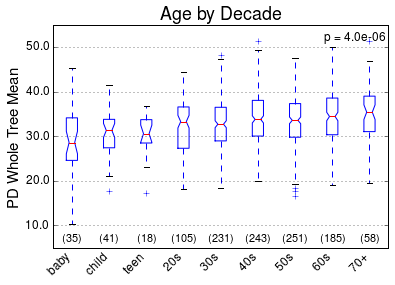

In [44]:
# Renders the boxplot
alpha_ax = div.pretty_pandas_boxplot(meta=data_map,
                                     group=category, 
                                     order=c_order,
                                     cat=a_div_metric,
                                     ylabel=a_ylabel,
                                     ylim=a_ylim,
                                     title=a_title,
                                     xfont_angle=xtick_angle,
                                     xfont_align=xtick_align)
if save_images:
    alpha_fig = alpha_ax.figure
    alpha_fig.savefig(image_pattern % {'div_metric': a_div_metric, 
                                       'image_type': 'boxplot', 
                                       'category': category.lower()},
                      pad_inches=save_pad,
                      bbox_inches=save_bbox)

# Displays the post-hoc table
alpha_post = div.post_hoc_pandas(meta=data_map,
                                 group=category, 
                                 order=c_order,
                                 cat=a_div_metric,
                                 correct=a_correct)
alpha_post


**[Discussion of our alpha alpha diversity]**

<a href="#top">Return to the top</a>

<a id="beta"></a>
##Beta Diversity

Beta diversity allows us to compare observations or samples (groups of observations). So, if we go back to our example of an acre within Central Park and an acre with Yellowstone, we might find some similarities but we will also likely find differences. For example, both communities may contain mice, squirrels, and humans. However, while Bison are probably common in Yellowstone, it’s a lot less likely that we’ll find them in New York City. 

As with alpha diversity, our beta diversity metrics can be qualitative or quantitative and taxonomic or phylogenetic. A commonly used taxonomic metric is Bray-Curtis distance, while UniFrac is a popular phylogenetic beta diversity metric [<a href="#16332807">16332807</a>, <a href="curtis">curtis</a>]. We can use two types of UniFrac distance: unweighted (qualitative) or weighted (quantitative). While we have calculated both weighted and unweighted UniFrac tables, we will focus on unweighted UniFrac distance, here.

**[Discussion of previous beta diversity findings.]**

We will plot our beta diversity results as a barchart with significance bars. Beta diversity examines intra and inter sample distance. So, the barcharts we generate will have a reference group, which compares the distance between the samples in the group. This distance will be compared to the distance between the samples in the reference group and the samples in the other group. When significance bars are used, the reference group can be identified as the group from which all significance bars originate.<br />
The parameters for the bar charts, like the coloring and text size, can be set <a href="dir_bdiv">above</a>.

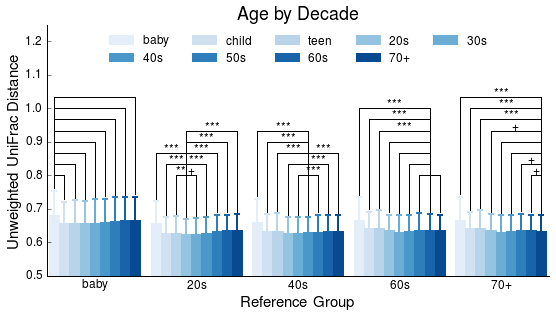

In [52]:
# Performs post-hoc analysis comparing categories
if not os.path.exists(bdiv_post_fp) or overwrite:
    !make_distance_boxplots.py -d $data_ubd_fp -m $data_map_fp -f $category -o $bdiv_data_metric_dir --suppress_all_between --suppress_all_within -n $post_n_iter

# Loads the post-hoc table for category
post_hoc_ubd = pd.read_csv(bdiv_post_fp,
                           sep=txt_delim,
                           skiprows=7)
# Plots the unweighted UniFrac
beta_ax = div.beta_diversity_bars(data_ubd, data_map, category, 
                                  order=c_order, 
                                  ref_groups=['baby', '20s', '40s', '60s', '70+'],
                                  num_iter=permanova_n_iter,
                                  p_table=post_hoc_ubd,
                                  p_tab_col=p_column,
                                  ylim=[0.5, 1.25],
                                  colormap=bc_map,
                                  ylabel=ubd_ylabel,
                                  show_seperation=False,
                                  title=b_title)
beta_fig = beta_ax.get_figure()
beta_fig.set_size_inches(9, 4.5)

if save_images:
    beta_fig.savefig(image_pattern % {'div_metric': b_div_metric, 
                                      'image_type': 'barchart', 
                                       'category': category.lower()},
                      pad_inches=save_pad,
                      bbox_inches=save_bbox)

The bar charts are read as the distance between the reference group and the group in the bar color. So, the very first bar in chart in the first reference group (labeled [**label**]) is the within-group distance for samples from healthy individuals [**descriptor**] compared to samples from healthy individuals [**describe text**]. The next bar ([**descriptor**]) is the between group distance for people [**descriptor**] compared to [**descriptor**]. [**Talk about the comparison**]

Significance is shown in the lines over the bars. An unlabeled line means that the inter-group distance is not significantly larger than the intragroup distance for that pair. Significance is coded using the following symbols:

<table>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               width:200px;
               text-align:center">
       <th style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  width:100px;
                  text-align:center">
           Max $p$
       </th>
       <th style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  width:100px;
                  text-align:center">
           Symbol
       </th>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.1
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>+</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.5
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.01
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               border-bottom:hidden;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.001
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*\*</code>
        </td>
    </tr>
    <tr style="border-left:hidden;
               border-right:hidden;
               border-collapse:collapse;
               text-align:center">
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
            0.0001
        </td>
        <td style="border-left:hidden;
                  border-right:hidden;
                  border-collapse:collapse;
                  text-align:center">
          <code>\*\*\*\*</code>
        </td>
    </tr>
</table>
Because we used a permutative test, remember the minimum p value can be no smaller than $\frac{1}{1 + n_{permutations}}$.

**[Beta Diveristy Discussion]**

<a href="#top">Return to the top</a>

<a id="#group"></a>
##Group Signifigance

While alpha diversity and beta diversity give us ideas about the structure of the communities, we can look for individual bacterial taxa which differ using individual tests. We use a [kruskal-wallis](http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance) test can be used to compare the abundances of different bacteria, since bacterial abundances are not normally distributed [<a href="#23284876">23284876</a>]. This test is closer to a weighted diveristy metric.

There is also a trend in microbiome that that compositional analysis, looking at the presence and absence of taxa, rather than their abundance. One approach to the presence, absence measurement is the [G test](http://en.wikipedia.org/wiki/G-test) or log-liklihood test. This test is closer to an unweighted diveristy metric.

**[Discussion of any significant taxa found previously]**

Our results are plotted as two heat maps. Each square in the heatmap represents the average abundance of the taxa in that sample. The heatmap on the left shows the raw abundance of bacteria in a sample. If default parameters are used, the darker the color, the more of that species is present. The heatmap on the right compares the amount of the sample present to the mean amount in all samples and then takes the log-ratio. In a logarithm, negative numbers represent a ratio less than 1 and positive numbers represent a value greater than 1.

We will start by generating the significance files, and then plot our kruskal wallis results as a heat map.

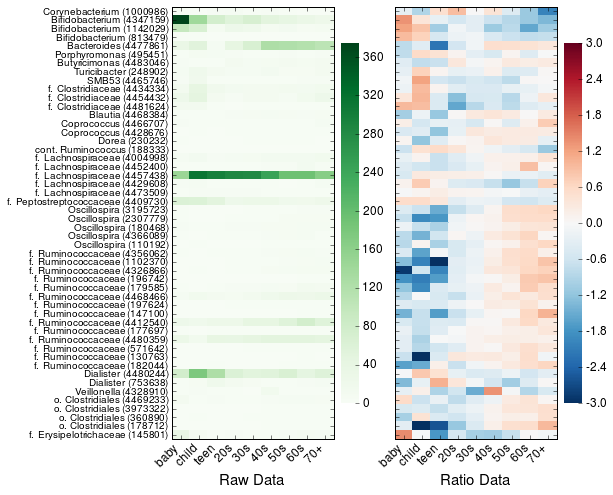

In [46]:
# Sets up the order of the groups for testing
h_order = ['%s_mean' %s for s in c_order]

# Performs the appropriate tests
if not os.path.exists(kruskal_fp) or overwrite:
    !group_significance.py -i $data_otu_fp -m $data_map_fp -c $category -o $kruskal_fp -s kruskal_wallis
if not os.path.exists(gtest_fp) or overwrite:
    !group_significance.py -i $data_otu_fp -m $data_map_fp -c $category -o $gtest_fp -s g_test

# Plots the kruskal wallis heatmap
if os.path.exists(kruskal_fp):
    kw_table = pd.read_csv(kruskal_fp, sep=txt_delim)
    [data_hm1_kw_ax, data_hm2_kw_ax], kw_feats = \
        div.make_dual_heatmaps(kw_table, 
                               h_order, 
                               cmap1=hm_cmap1, 
                               cmap2=hm_cmap2, 
                               clims2=hm_clims2, 
                               xtick_size=hm_xtick_size, 
                               ytick_size=hm_ytick_size,
                               p_crit=kw_crit,
                               xfont_angle=xtick_angle,
                               xfont_align=xtick_align)
    if save_images:
        kw_fig = data_hm1_kw_ax.figure
        kw_fig.savefig(image_pattern % {'div_metric': 'otu_kruskal', 
                                        'image_type': 'heatmap', 
                                        'category':category.lower()},
                       pad_inches=save_pad,
                       bbox_inches=save_bbox)

**[kruskal wallis discussion text]**

We can also look at the presence or absence of OTUs using a G-test.

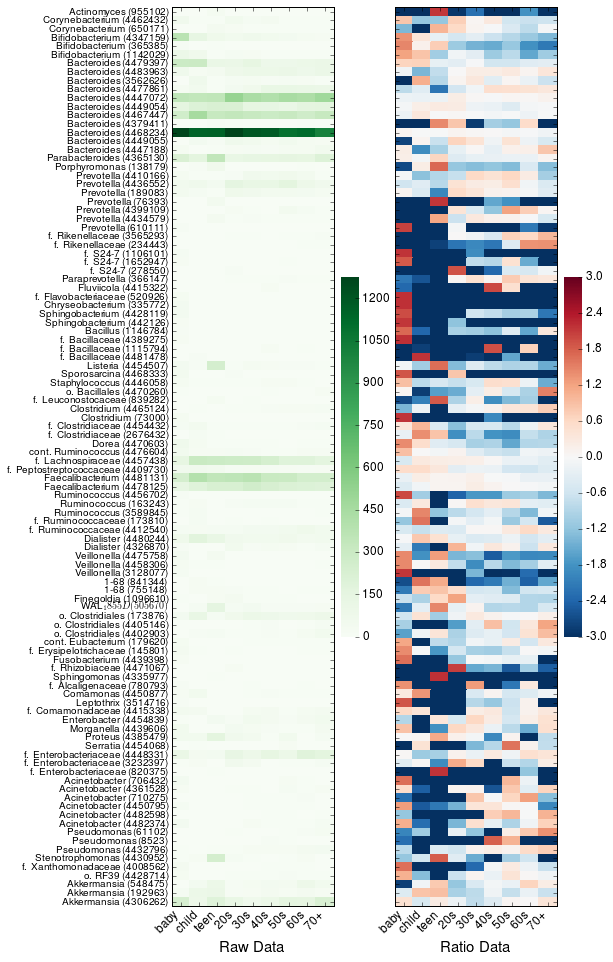

In [47]:
if os.path.exists(gtest_fp):
    gt_table = pd.read_csv(gtest_fp, sep=txt_delim)
    [data_hm1_gt_ax, data_cat_hm2_gt_ax], data_cat_gt_feats = \
        div.make_dual_heatmaps(gt_table, 
                               h_order, 
                               cmap1=hm_cmap1, 
                               cmap2=hm_cmap2, 
                               clims2=hm_clims2, 
                               xtick_size=hm_xtick_size, 
                               ytick_size=hm_ytick_size,
                               p_crit=gt_crit,
                               xfont_angle=xtick_angle,
                               xfont_align=xtick_align)
    if save_images:
        gt_fig = data_hm1_gt_ax.figure
        gt_fig.savefig(image_pattern % {'div_metric': 'otu_gtest', 
                                        'image_type': 'heatmap', 
                                        'category':category.lower()},
                       pad_inches=save_pad,
                       bbox_inches=save_bbox)

**[g test discussion text]**

**[Group signifigance discussion text]**

<a href="#top">Return to the top</a>

<a id="#discussion"></a>
##Discussion

**[Discussion text]**

<a href="#top">Return to the top</a>

<a id="#refs"></a>
## References
<ul><li><a id="22699611"></a>
Yatsunenko, T.; Rey, F.E.; Manary, M.J.; Trehan, I.; Dominguez-Bello, M.G.; Contreras, M.; Magris, M.; Hidalgo, G.; Baldassano, R.N.; Anokhin, A.P.; Heath, A.C.; Warner, B.; Rdder, J.; Kuczynski, J.; Caporaso, J.G.; Lozupone, C.A.; Lauber, C.; Clemente, J.C.; Knights, D.; Knight, R. and Gordon, J.I. (2012) “<a href="http://www.ncbi.nlm.nih.gov/pubmed/22699611">Human Gut microbiome viewed across age and geography</a>.” <em>Nature</em>. **486**: 222-227.   

<br>   </li><li><a id="22699609"></a>
The Human Microbiome Consortium. (2012) “[Structure, Function and diversity of the healthy human microbiome](http://www.ncbi.nlm.nih.gov/pubmed/22699609).” *Nature*. **486**: 207-214.  

<br>   </li><li><a id="21624126"></a>
Caporaso, J.G.; Lauber, C.L.; Costello, E.K.; Berg-Lyons, D.; Gonzalez, A.; Stombaugh, J.; Knights, D.; Gajer, P.; Ravel, J.; Fierer, N.; Gordon, J.I.; and Knight, R. (2011) “[Moving picture of the human microbiome](http://www.ncbi.nlm.nih.gov/pubmed/21624126
).” *Genome Biol*. **12**: R50.  

<br>   </li><li><a id="21885731"></a>
Wu, G.D.; Chen, J.; Hoffmann, C.; Bittinger, K.; Chen, Y.Y.; Keilbaugh, S.A.; Bewtra, M.; Knights, D.; Walters, W.A.; Knight, R.; Sinah, R.; Gupta, K.; Baldassano, R.; Nessel, L.; Li, H.; Bushman, F.D.; Lewis, J.D. (2011) “[Linking long-term dietary patterns with gut microbiome enterotypes](http://www.ncbi.nlm.nih.gov/pubmed/21885731).” *Science*. **334**: 105-108.  

<br>   </li><li><a id="15831718"></a>
Eckburg, P.B.; Bik, E.M.; Bernstein C.N.; Purdom, E.; Dethlefson, L.; Sargent, M.; Gill, S.R.; Nelson, K.E.; Relman, D.A. (2005) “[Diversity of the human intestinal microbial flora](http://www.ncbi.nlm.nih.gov/pubmed/15831718).”   *Science*. **308**: 1635-1638.

<br>   </li><li><a id="Chao1"></a>
Chao, A. (1984) “[Nonparametric estimation of the number of classes in a population](http://viceroy.eeb.uconn.edu/estimateS/EstimateSPages/EstSUsersGuide/References/Chao1984.pdf).” *Scandinavian J Stats*. **11**: 265-270.  

<br>   </li><li><a id="Shannon"></a>
Seaby, R.M.H. and Henderson, P.A. (2006). “[Species Diversity and Richness 4](http://www.pisces-conservation.com/sdrhelp/index.html).”  

<br>   </li><li><a id="16332807"></a>
Lozupone, C.; and Knight, R. (2005). “[UniFrac: a new phylogenetic method for comparing microbial communities](http://www.ncbi.nlm.nih.gov/pubmed/16332807).” *Appl Enviro Microbiol*. **71**: 8228-8235.  

<br>   </li><li><a id="Bondini"></a>
Bondini, M.E.; Mielke, P.W.; Berry, K.J. (1988) “[Data-dependent permutation techniques for the analysis of ecological data](http://www.ndsu.edu/pubweb/~biondini/vita/0120_Vegetatio_1988_Biondini.pdf
).” Vegetatio. 75: 161-168  

<br>   </li><li><a id="18939983"></a>
Camargo, A.; Azuaje, F.; Wang, H.; and Zheng, H. (2008) “[Permutation-based statistical tests for multiple hypotheses](http://www.ncbi.nlm.nih.gov/pubmed/18939983).” *Source Code Biol Med*. **21**:15.   

<br>   </li><li><a id="23587224"></a>
McDonald, D.; Clemente, J.C.; Kuczynski, J.; Rideout, J.R.; Stombaugh, J.; Wendel, D.; Wilke, A.; Huse, S.; Hufnagle, J.; Meyer, F.; Knight, R.; and Caporaso, J.G. (2012). “[The Biological Observation Matrix (BIOM) format or: how I learned to stop worrying and love the ome-ome](http://www.ncbi.nlm.nih.gov/pubmed/23587224).” *Gigascience*. **1**:7.  

<br>   </li><li><a id="16332807"></a>
Wang, Q.; Garrity, G.M.; Tiedje, J.M.; and Cole, J.R. (2007) “[Naive bayesian classifier for rapid assignment of rRNA sequences into the new bacterial taxonomy](http://www.ncbi.nlm.nih.gov/pubmed/17586664).” *Appl Environ Microbiol*. **73**: 5261 - 5267.  

<br>   </li><li><a id="curtis"></a>
Bray, J.R.; and Curtis, J.T. (1957) “[An ordination of the upland forest communities of southern Wisconsin](http://www.geobotany.org/teaching/biol474/journals/Bray1957v27n4.pdf).” *Ecol Monographs*. **27**: 325 - 349.  

<br>   </li><li><a id="23284876"></a>
La Rosa, P.S.; Brooks, J.P.; Deych, E.; Boone, E.L.; Edwards, D.J.; Wang, Q.; Sodergren, E.; Weinstock, G.; Shannon, W.D. (2012) “[Hypothesis testing and power calculations for taxonomic-based human microbiome data](http://www.ncbi.nlm.nih.gov/pubmed/23284876).” *PloS One*. **7**:e52078.  

<br>   </li></ul>